In [1]:
import os

import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook
from torchsummary import summary
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision

from torchvision import transforms, utils, datasets

sns.set(font_scale=1.4, style="whitegrid")

In [2]:
device = torch.device("cpu")
device

device(type='cpu')

In [3]:
classes = ('af', 'an', 'di', 'ha',
           'ne', 'sa', 'su')

def get_dataloaders(batch_size):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Resize((312, 440)),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    trainset = torchvision.datasets.ImageFolder(root='./data_emo/train', transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.ImageFolder(root='./data_emo/test', transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    return trainloader, testloader

In [4]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_losses = []
    val_losses = []
    valid_accuracies = []
    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        for xb, yb in tqdm_notebook(train_dl):
            xb, yb = xb.to(device), yb.to(device)
            
            loss = loss_func(model(xb), yb)
            loss_sum += loss.item()
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_losses.append(loss_sum / len(train_dl))

        model.eval()
        loss_sum = 0
        correct = 0
        num = 0
        with torch.no_grad():
            for xb, yb in tqdm_notebook(valid_dl):
                xb, yb = xb.to(device), yb.to(device)
                
                probs = model(xb)
                loss_sum += loss_func(probs, yb).item()
                
                _, preds = torch.max(probs, axis=-1)
                correct += (preds == yb).sum().item()
                num += len(xb)
                
        val_losses.append(loss_sum / len(valid_dl))
        valid_accuracies.append(correct / num)
            
        if correct / num > 0.90:
            return train_losses, val_losses, valid_accuracies
        
    return train_losses, val_losses, valid_accuracies

In [5]:
def plot_trainig(train_losses, valid_losses, valid_accuracies):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(train_losses, label="train_loss")
    plt.plot(valid_losses, label="valid_loss")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()

In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(108800, 120)  # 5x5 image dimension
        self.bn7 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 94)
        self.bn8 = nn.BatchNorm1d(94)
        self.fc = nn.Linear(94, 64)
        self.fc3 = nn.Linear(64, 7)

    def forward(self, x):
        x = self.bn1(F.max_pool2d(F.relu(self.conv1(x)), (2, 2)))
        x = self.bn2(F.max_pool2d(F.relu(self.conv2(x)), 2))
        x = self.bn3(F.max_pool2d(F.relu(self.conv3(x)), 2))
        x = self.bn4(F.max_pool2d(F.relu(self.conv4(x)), 2))
        x = x.view(x.shape[0], -1)
        x = self.bn7(F.relu(self.fc1(x)))
        x = self.bn8(F.elu(self.fc2(x)))
        x = F.elu(self.fc(x))
        
        x = self.fc3(x)
        return x

In [7]:
model = Model().to(device)
summary(model, (3, 312, 440))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 308, 436]           1,216
       BatchNorm2d-2         [-1, 16, 154, 218]              32
            Conv2d-3         [-1, 64, 152, 216]           9,280
       BatchNorm2d-4          [-1, 64, 76, 108]             128
            Conv2d-5         [-1, 128, 74, 106]          73,856
       BatchNorm2d-6          [-1, 128, 37, 53]             256
            Conv2d-7          [-1, 256, 35, 51]         295,168
       BatchNorm2d-8          [-1, 256, 17, 25]             512
            Linear-9                  [-1, 120]      13,056,120
      BatchNorm1d-10                  [-1, 120]             240
           Linear-11                   [-1, 94]          11,374
      BatchNorm1d-12                   [-1, 94]             188
           Linear-13                   [-1, 64]           6,080
           Linear-14                   

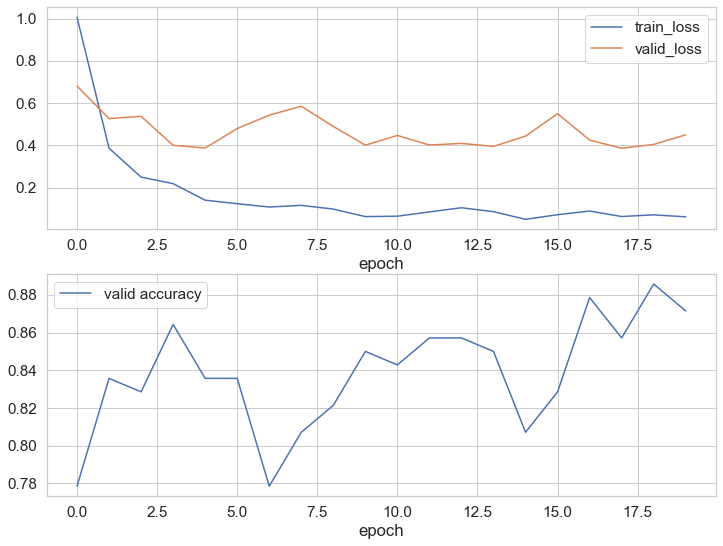

In [8]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=0.01, betas=(0.9, 0.999))

info = fit(20, model, criterion, optimizer, *get_dataloaders(16))
plot_trainig(*info)

In [9]:
def test_model(model):
    class_correct = list(0. for i in range(7))
    class_total = list(0. for i in range(7))
    _, test_dl = get_dataloaders(4)
    
    with torch.no_grad():
        for data in test_dl:
            images, labels = data
            y_pred = model(images.to(device))#.view(4, -1))
            _, predicted = torch.max(y_pred, 1)
            c = (predicted.cpu().detach() == labels).squeeze()
            for i in range(c.shape[0]):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    for i in range(7):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    print(sum(class_correct)/sum(class_total))

In [10]:
test_model(model)

Accuracy of    af : 85 %
Accuracy of    an : 85 %
Accuracy of    di : 95 %
Accuracy of    ha : 95 %
Accuracy of    ne : 90 %
Accuracy of    sa : 70 %
Accuracy of    su : 90 %
0.8714285714285714


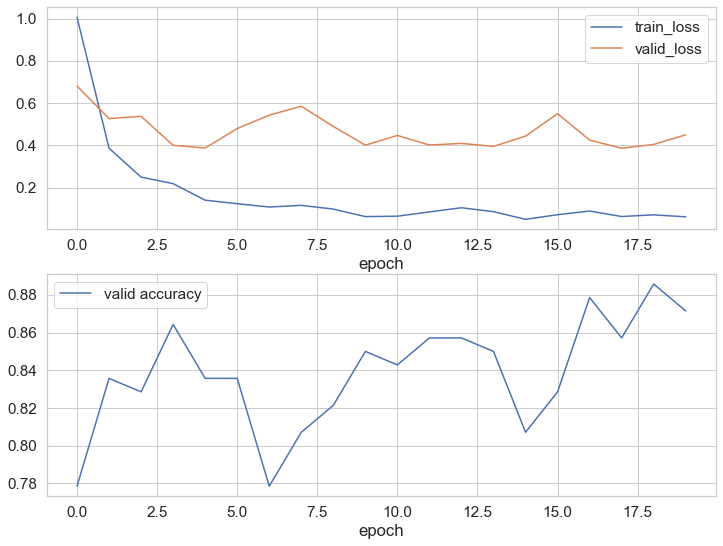

In [12]:
plot_trainig(*info)